In [1]:
# 주요 import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 주피터 셸에서 모두 출력하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 데이터 불러오기

##데이터 세트의 주요 컬럼##
- 주로 사용할 컬럼 정리

In [2]:
data_PATH = "./datasets/house_prices_advanced_regression_techniques/"
house_df_org = pd.read_csv(data_PATH + 'house_train.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


=> target 값은 SalePrice 컬럼

# 데이터 전처리

## 데이터셋 확인

In [3]:
# 데이터 전체적으로 확인
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


=> house 데이터는 1460개의 레코드와 81개의 피처로 구성  
=> 피처는 43개의 문자형, 38개의 숫자형으로 구성  
=> Null값이 많이 존재 (1000개가 넘는 데이터가 Null값인 컬럼은 제거)

## target값 확인 후 로그 변환

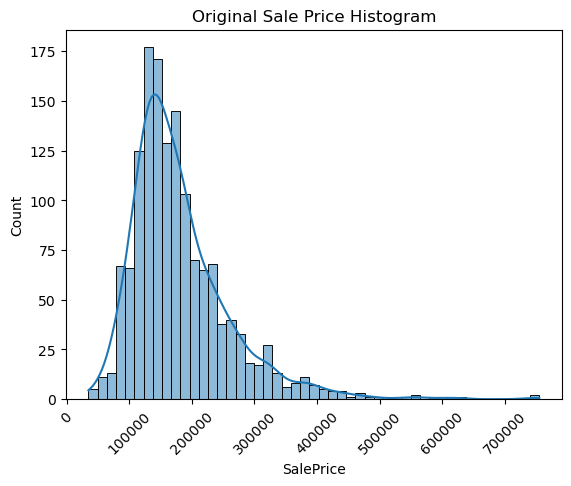

In [4]:
# target값인 'SalePrice' 컬럼 분포도 확인
sns.histplot(house_df['SalePrice'], kde=True);
plt.title('Original Sale Price Histogram');
plt.xticks(rotation=45);
plt.show();

=> SalePrice 컬럼이 정규 분포를 이루고 있지 않음 (왼쪽으로 편향, 로그를 적용해 변형)

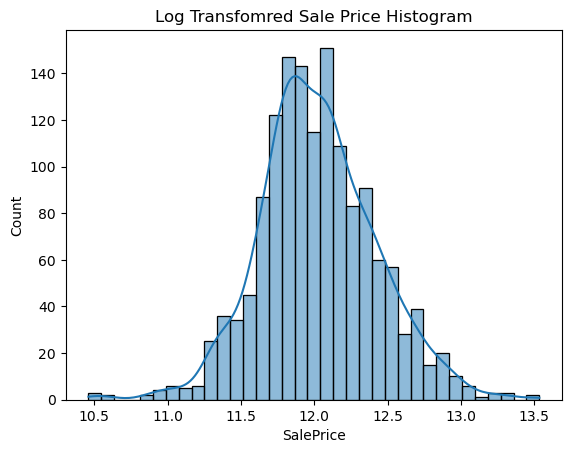

In [5]:
# 로그 변환 (log1p()로 로그 변환한 결과값을 기반으로 학습 -> 예측시에는 다시 결과값을 expm1()으로 환원)
log_SalePrice = np.log1p(house_df['SalePrice'])

sns.histplot(log_SalePrice, kde=45)
plt.title('Log Transfomred Sale Price Histogram');
plt.show();

=> 로그 변환 후 SalePrice 값이 정규 분포 형태로 분포

In [6]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

## Null 값 처리

In [7]:
# Null 값이 너무 많은 컬럼과 불필요한 컬럼 제거
drop_columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id', 'FireplaceQu']
house_df.drop(drop_columns, axis=1, inplace=True)

# 제거하지 않은 숫자형 Null 값은 평균값으로 대체
num_col = house_df.select_dtypes(include=['int', 'float']).columns
house_df[num_col] = house_df[num_col].fillna(house_df[num_col].mean())

In [8]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type: \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type: 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


=> 문자형 피처를 제외하고는 Null 값이 없음 (문자형은 원-핫 인코딩으로 변환)

### 원-핫 인코딩

In [9]:
print('get_dummies() 수행 전 데이터 Shape: ', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape: ', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('\n## Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape:  (1460, 75)
get_dummies() 수행 후 데이터 Shape:  (1460, 270)

## Null 피처의 Type: 
 Series([], dtype: object)


=> 원-핫 인코딩 후 피처가 75개에서 270개로 증가  
=> Null 값을 가진 피처 없음

# 머신러닝 학습/예측/평가

## 모델 평가 지표

In [10]:
# get_rmse(model)는 단일 모델의 RMSE 값 반환
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

# get_rmses(models)는 get_rmse()를 이용해 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses= [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

## 선형 회귀 모델

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression()

Ridge()

Lasso()

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250485, 0.12740582836266195, 0.17628250556471395]

=> Lasso 회귀의 경우 회귀 성능이 다른 회귀 방식보다 떨어짐 (최적 하이퍼 파라미터 튜닝 필요)

### 피처별 회귀 계수 시각화

In [12]:
# 회귀 계수 값의 상위 10개, 하위 10개
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수 추출
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

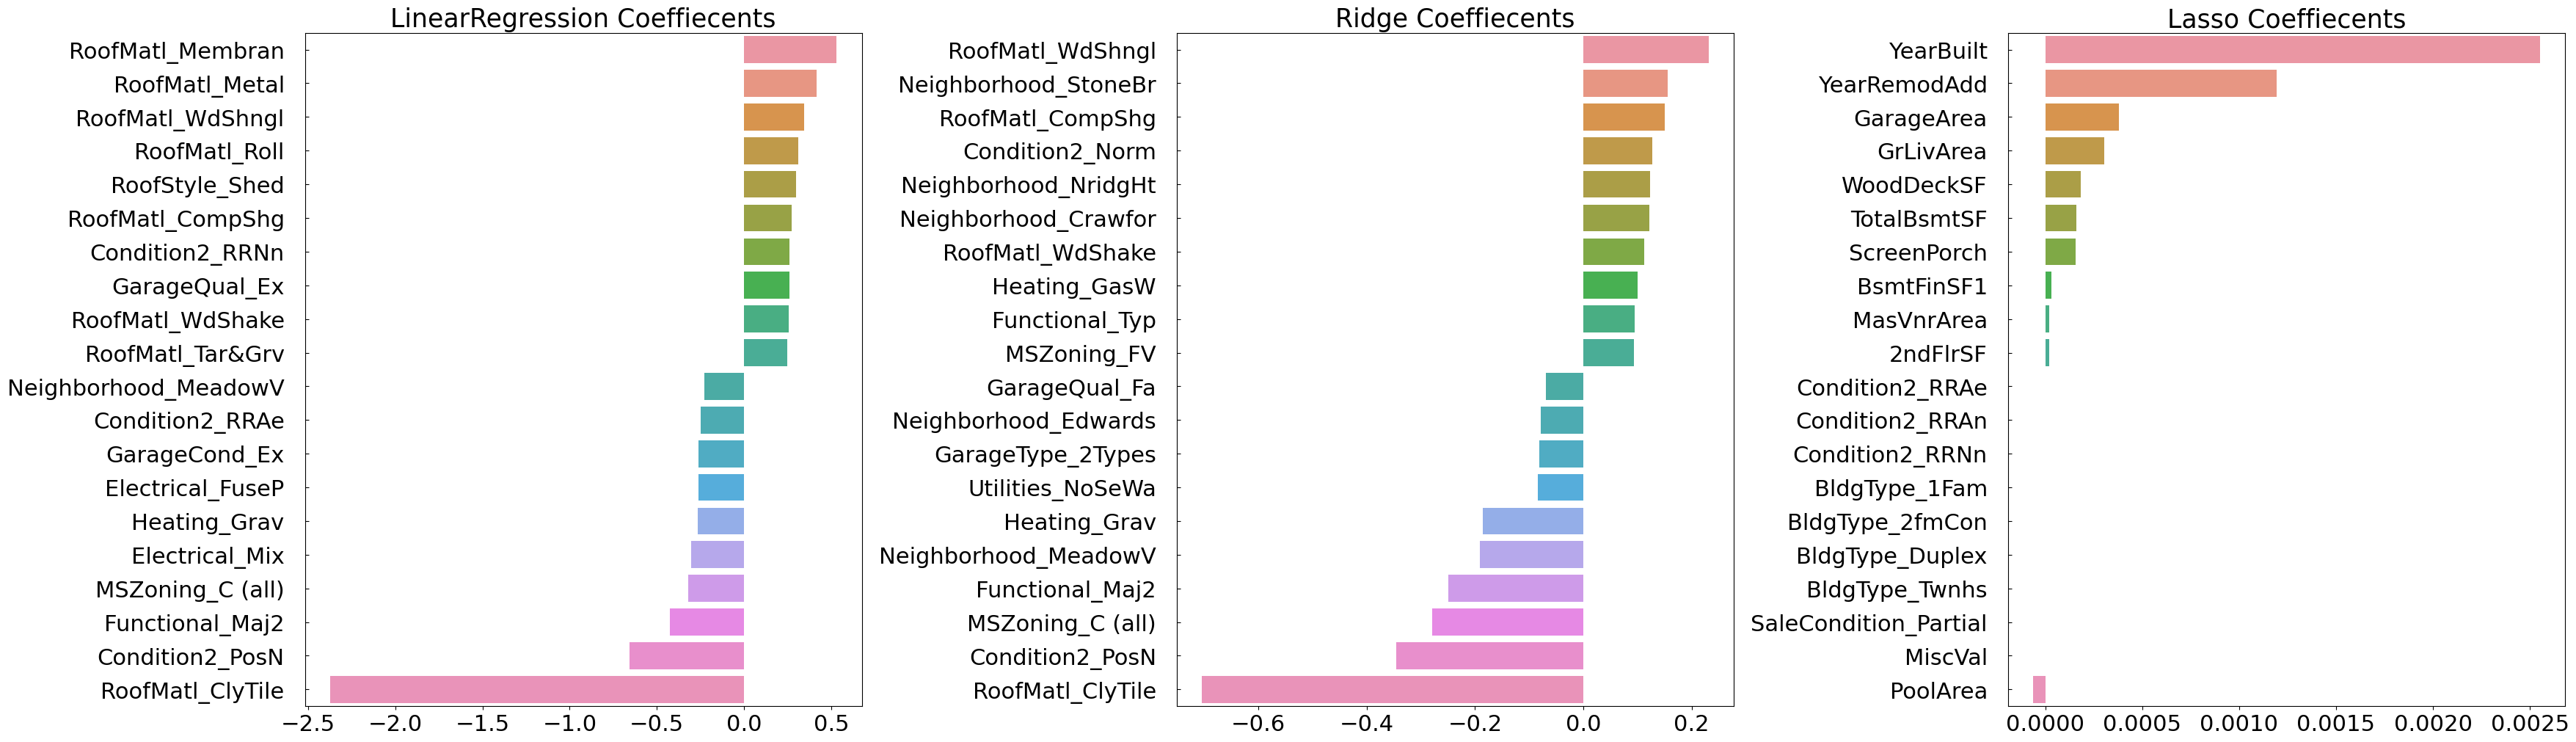

In [13]:
# 모델별 회귀 계수 시각화
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(35, 10), nrows=1, ncols=3, constrained_layout=True)
    #fig.tight_layout()
    
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고 판다스 concat으로 결합
        coef_higt, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_higt, coef_low])
        
        # ax subplot에 barchar로 표현(한 화면에 표현하기 위해 tick label위치, font 크기 조정)
        axs[i_num].set_title(model.__class__.__name__ + ' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=20)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

=> LinearRegression와 Ridge는 회귀 계수가 유사한 형태로 분포  
=> Lasso는 전체적으로 회귀 계수값이 작고, 다른 두개의 모델과 다른 회귀 계수 형태를 보임 (학습/테스트 데이터 다시 분리)

In [14]:
# 학습/테스트 데이터를 5개의 교차 검증 폴드 세트로 분할
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행, 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
        
# 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


=> 5개의 폴드 세트로 학습한 후 평가해도 Lasso 모델이 Ridge 모델보다 성능이 떨어짐 (alpha 하이퍼 파리미터 변화)

In [15]:
# 최적화 alpha 값 추출
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring="neg_mean_squared_error", cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__, 
                                                               np.round(rmse, 4), grid_model.best_params_))
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha: {'alpha': 0.001}


=> Ridge 모델은 alpha가 12에서 최적 평균 RMSE 값이 0.1418  
=> Lasso 모델은 alpha가 0.001에서 최적 평균 RMSE 값이 0.142 (alpha 값 최적화 이후 예측 성능 좋아짐)

LinearRegression()

Ridge(alpha=12)

Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


[0.13183184688250485, 0.12386974257131543, 0.11995999858899732]

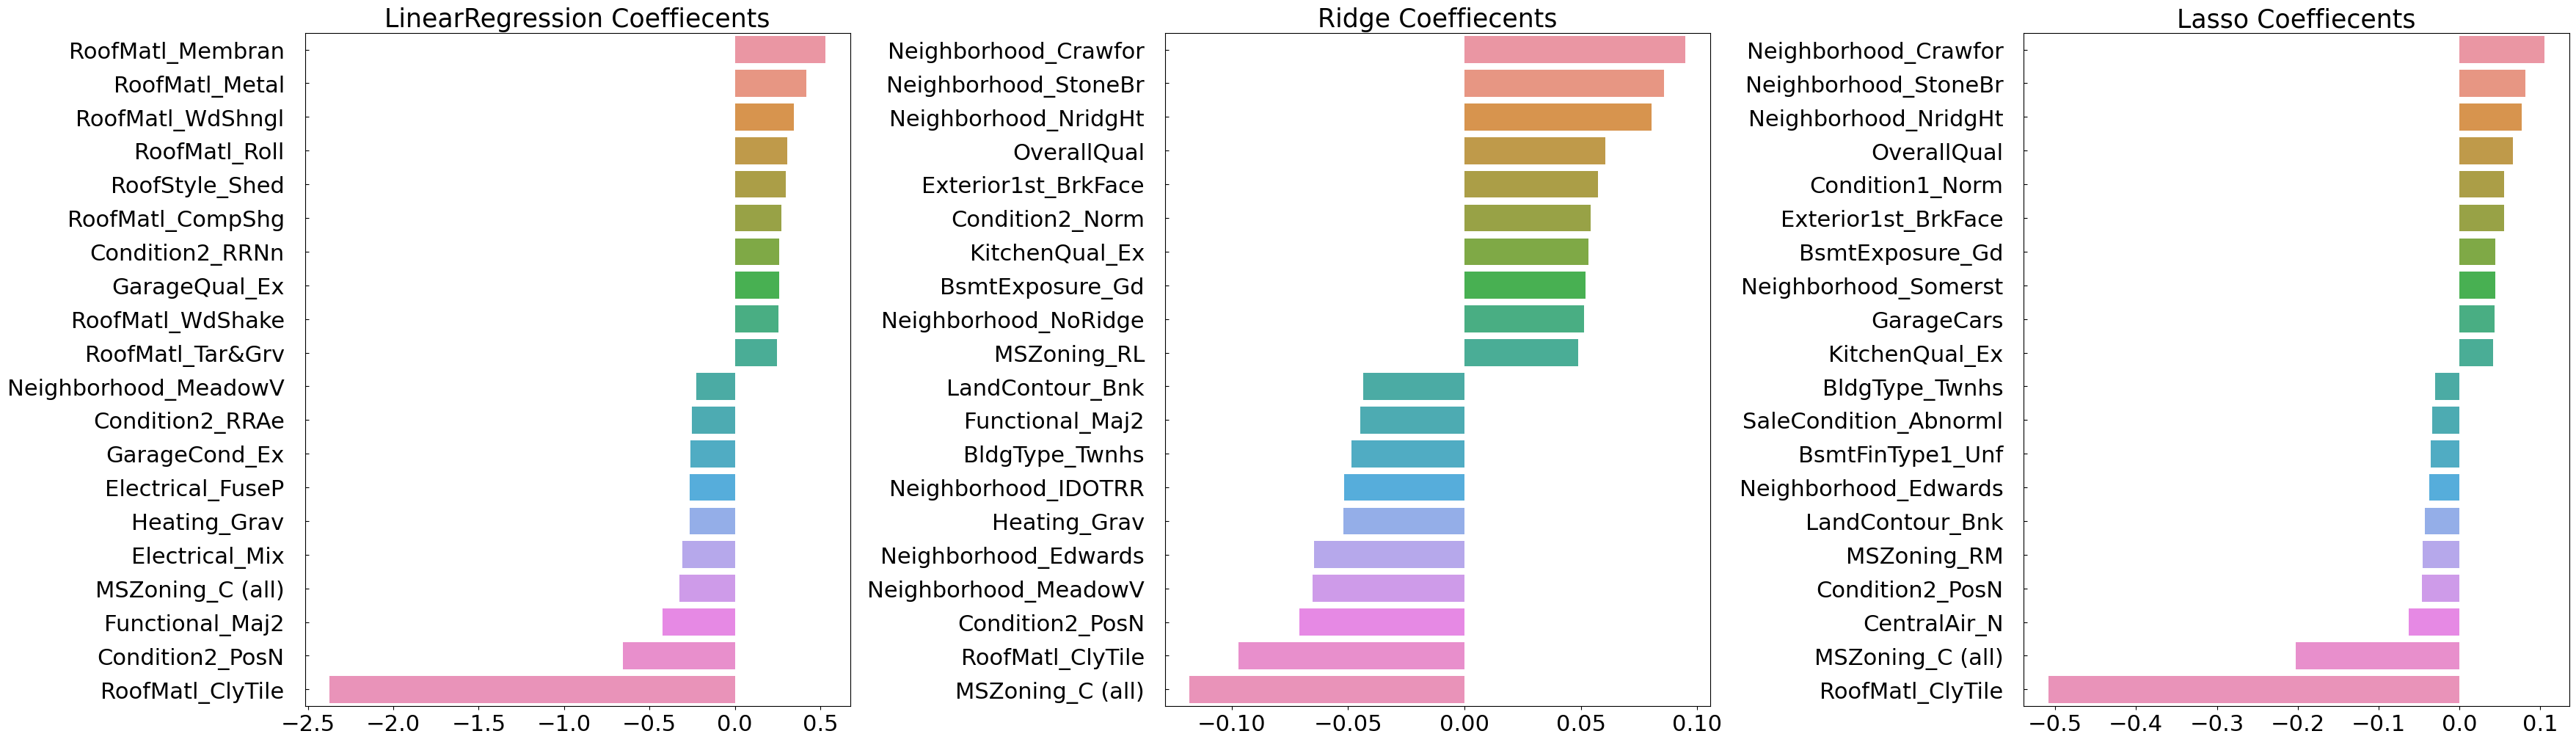

In [16]:
# 앞의 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측/평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

=> alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아짐  
=> 3개 모델의 회귀 계수 형태가 비슷해짐

# 데이터셋 추가 가공

## 피처 데이터 세트의 데이터 분포도

In [17]:
# 숫자형 피처의 왜곡 정도 확인
from scipy.stats import skew

# object가 아닌 숫자형 피처의 컬럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 세트 반환
# apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew(왜곡) 정도가 1이상인 컬럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [18]:
# 왜곡 정도가 높은 피처를 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [19]:
# 원-핫 인코딩 추가 적용하고 학습/테스트 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha: {'alpha': 0.001}


=> Ridge 모델의 경우 alpha값이 12에서 10으로 변경되었고, 최적 평균 RMSE 값은 0.1418에서 0.1275로 향상  
=> Lasso 모델의 경우 alpha값은 0.001로 변경 없고, 최적 평균 RMSE 값은 0.142에서 0.1252로 향상

LinearRegression()

Ridge(alpha=10)

Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


[0.12814976686433627, 0.1224955872818429, 0.11925537715945182]

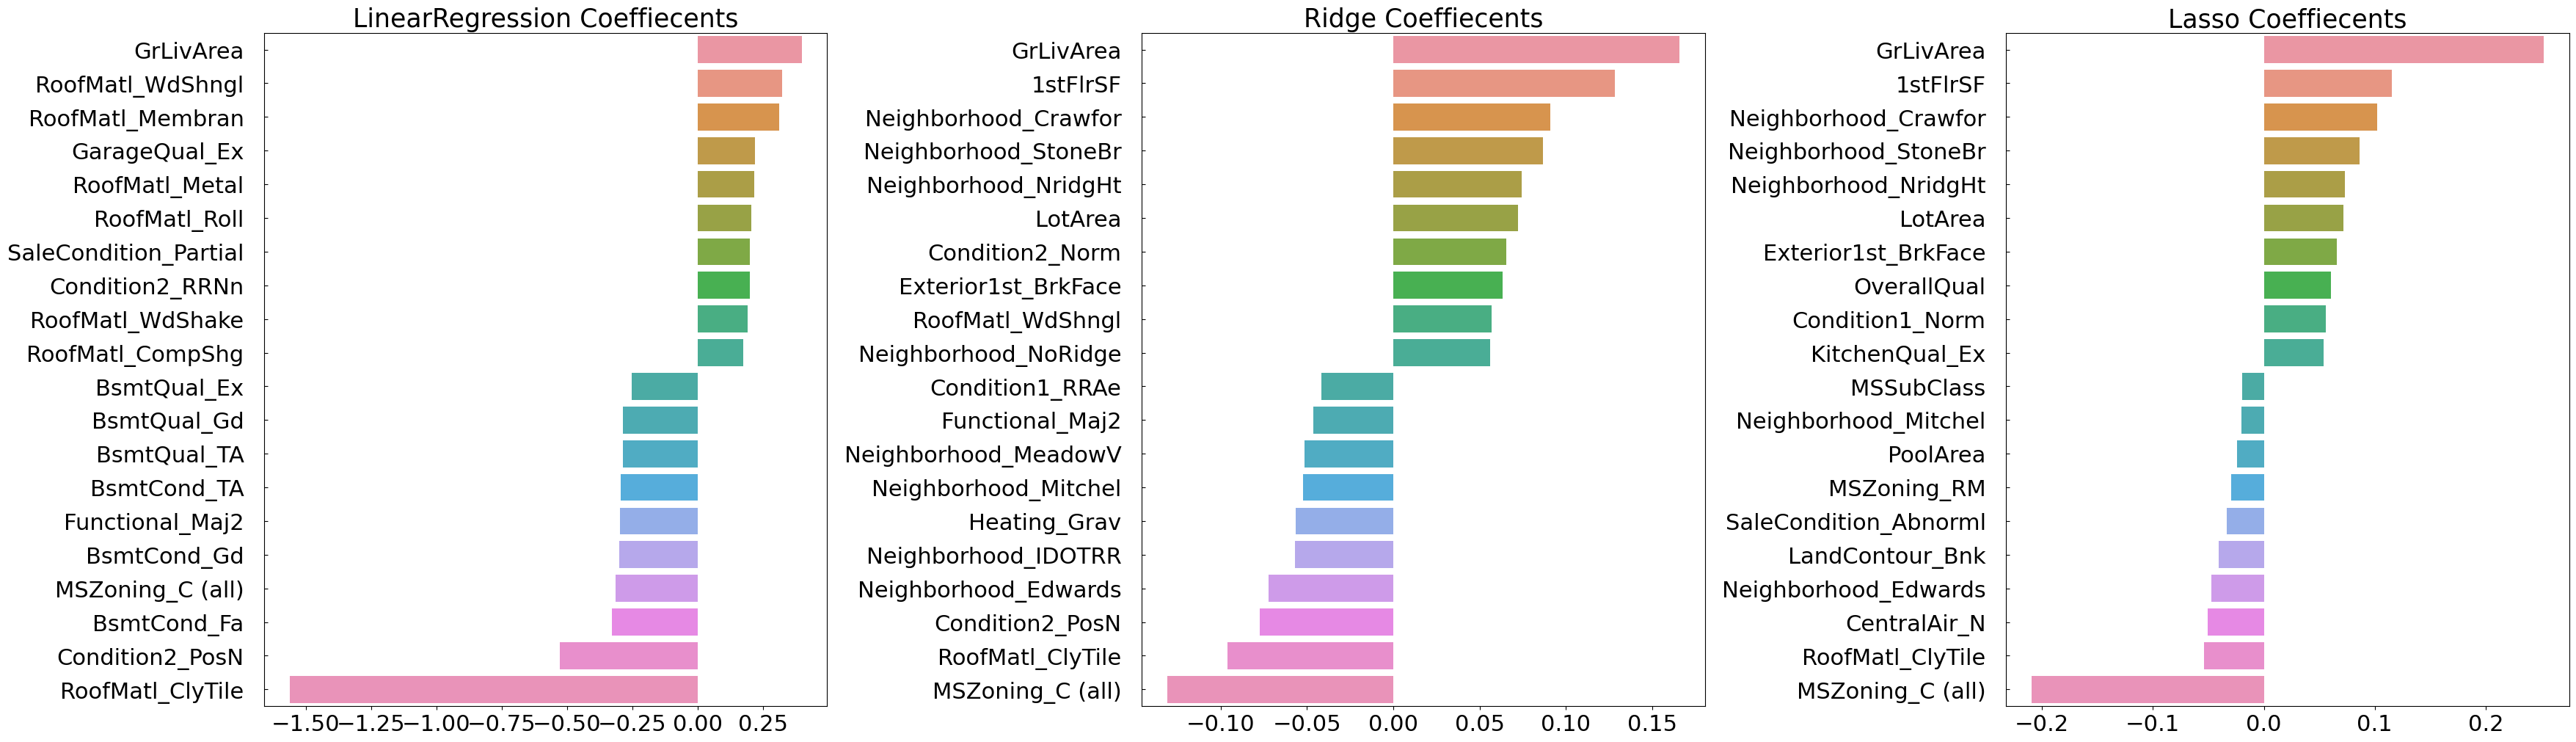

In [20]:
# 앞의 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측/평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

=> 세 모델 모두 'GrLivArea(주거 공간 크기)'의 회귀 계수가 가장 높은 피처  
=> 주거 공간의 크기가 주택 가격에 미치는 영향이 제일 높을 것이라는 가설에 대한 결과 도출

## 이상치 처리

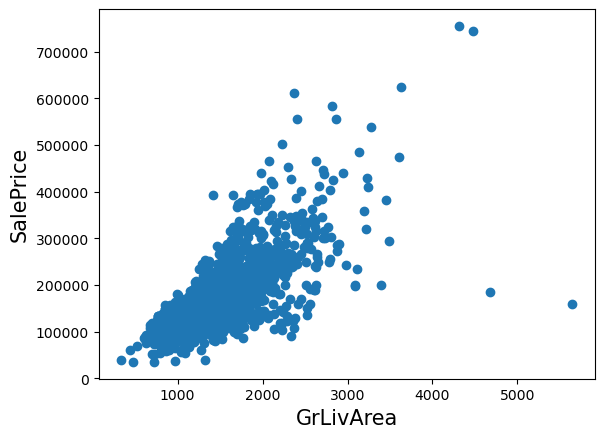

In [21]:
# GrLivArea 피처의 데이터 분포 시각화
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice']);
plt.xlabel('GrLivArea', fontsize=15);
plt.ylabel('SalePrice', fontsize=15);
plt.show();

=> 일반적으로 주거 공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 높음  
but 오른쪽 하단 2개의 데이터는 이상치로 간주

In [22]:
# GrLivArea와 SalePrice 모드 로그 변환되었으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('\n이상치 삭제 전 house_df_ohe Shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('\n이상치 삭제 후 house_df_ohe Shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]

이상치 삭제 전 house_df_ohe Shape: (1460, 270)

이상치 삭제 후 house_df_ohe Shape: (1458, 270)


=> 레코드 인덱스 523, 1298이 대상이고 두 개의 데이터를 삭제해 전체 레코드는 1460개에서 1458개로 줄었음

In [23]:
# 업데이트 된 house_df_ohe를 기반으로 학습/테스트 데이터 세트 다시 생성
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

# Lidge와 Lasso 모델의 최적화 수행
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha: {'alpha': 0.001}


=> Ridge 모델의 경우 alpha값이 10에서 8로 변경, 최적 평균 RMSE 값은 0.1275에서 0.1125로 향상  
=> Lasso 모델의 경우 alpha값은 0.001로 변경 없고, 최적 평균 RMSE 값은 0.1252에서 0.1122로 향상  
=> 두 개의 이상치를 제거했는데, 예측 수치가 매우 크게 향상

LinearRegression()

Ridge(alpha=8)

Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


[0.12865360466046374, 0.10340697165289345, 0.10024171179335353]

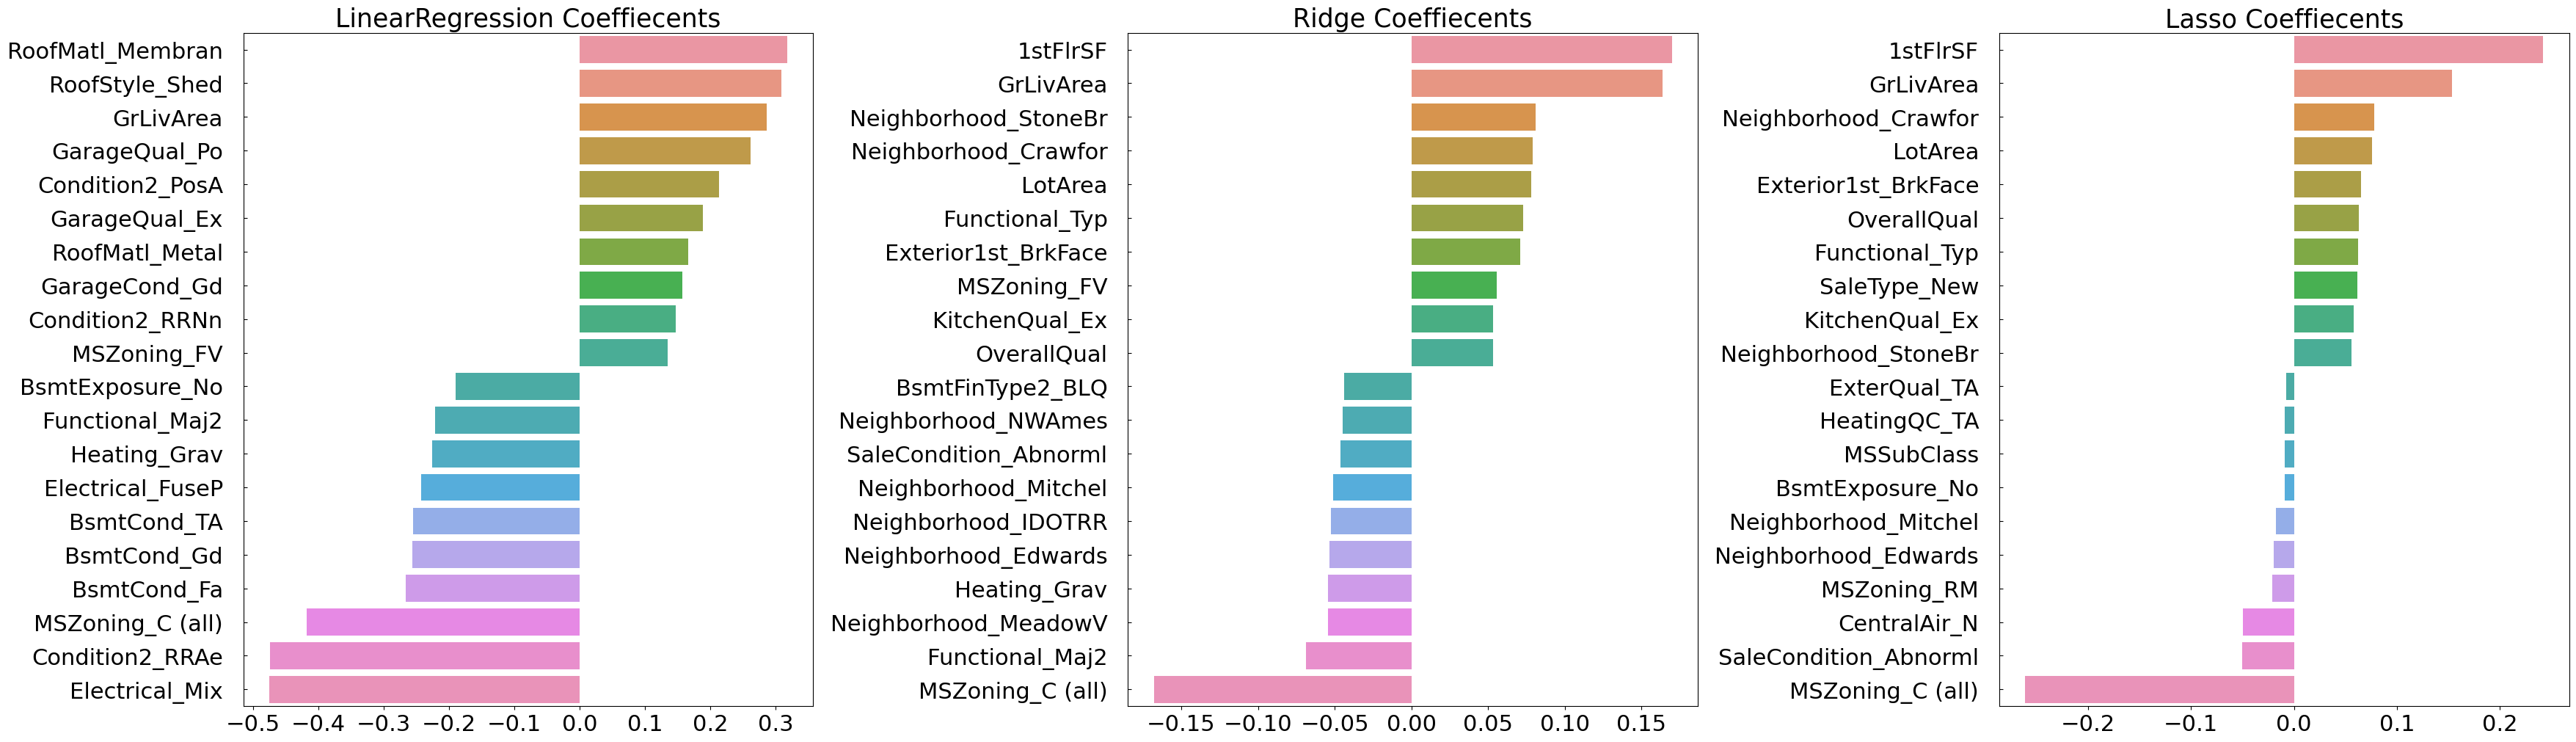

In [24]:
# 앞의 최적화 alpha 값으로 학습 데이터 학습, 테스트 데이터로 예측/평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# 회귀 트리 모델 학습/예측/평가

## XGBoost

In [25]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)
best_xgb

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1174, 최적 alpha: {'n_estimators': 1000}


=> XGBoost 회귀 트리를 적용하면, 5 폴드 세트 평균 RMSE가 0.1174

## LightGBM

In [26]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)
best_lgbm

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1179, 최적 alpha: {'n_estimators': 1000}


=> LightGBM 적용하면, 5 폴드 세트 평균 RMSE가 0.1179

## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

## Ridge + Lasso

In [27]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))
        
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출 (성능이 조금 더 좋은 쪽에 가중치를 더 둠)
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개녈 모델의 RMSE 값 출력
get_rmse_pred(preds)

Ridge(alpha=8)

Lasso(alpha=0.001)

최종 혼합 모델의 RMSE: 0.10006075517615198
Ridge 모델의 RMSE: 0.10340697165289345
Lasso 모델의 RMSE: 0.10024171179335353


=> 최종 혼합 모델의 RMSE가 개별 모델보다 약간 개선됨

## XGBoost + LightGBM

In [28]:
# 개별 모델의 학습
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)

lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

# 개별 모델 예측
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

# 최종 혼합 모델, 개녈 모델의 RMSE 값 출력
get_rmse_pred(preds)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

LGBMRegressor(colsample_bytree=0.4, learning_rate=0.05, n_estimators=1000,
              num_leaves=4, reg_lambda=10, subsample=0.6)

최종 혼합 모델의 RMSE: 0.10230054833466655
XGBM 모델의 RMSE: 0.10682829901857346
LGBM 모델의 RMSE: 0.10363891833477148


=> 최종 혼합 모델의 RMSE가 개별 모델보다 조금 향상

# 스태킹 앙상블 모델을 통한 회귀 예측

In [29]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_fols):
    # 지정된 n_fols 값으로 KFold 생성
    kf = KFold(n_splits=n_fols, shuffle=False)
    
    # 추후 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_fols))
    print(model.__class__.__name__, ' model 시작 ')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [30]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [31]:
# Lasso 모델의 최적화 수행
lasso_params = {'alpha':[0.0005, 0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(lasso_reg, lasso_params)

Lasso 5 CV 시 최적 평균 RMSE 값: 0.11, 최적 alpha: {'alpha': 0.0005}


In [32]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 Lasso 모델 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 에측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

Lasso(alpha=0.0005)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09769360527528641


∴ 스태킹 회귀 모델을 적용한 결과, 테스트 데이터 세트에서 RMSE가 약 0.0977로 현재까지 가장 좋은 성능 평가를 보여줌